<a href="https://colab.research.google.com/github/twelvesense/first-repository/blob/master/ExplNode05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **프로젝트: 가위바위보 분류기를 만들자**

# 1 데이터 준비 

## 1-1. 필요한 라이브러리 불러오기

In [49]:
import warnings
warnings.filterwarnings("ignore")
import os
from PIL import Image
import glob
import numpy as np
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## 1-2. 가위바위보 이미지 파일 *download하기*

In [12]:
!mkdir -p /content/train/rock
!mkdir -p /content/train/paper
!mkdir -p /content/train/scissor
!mkdir -p /content/test/rock
!mkdir -p /content/test/paper
!mkdir -p /content/test/scissor
!wget -O /content/train/rock/rock.zip https://raw.githubusercontent.com/twelvesense/first-repository/master/data/rock_scissor_paper/rock.zip
!wget -O /content/train/paper/paper.zip https://raw.githubusercontent.com/twelvesense/first-repository/master/data/rock_scissor_paper/paper.zip
!wget -O /content/train/scissor/scissor.zip https://raw.githubusercontent.com/twelvesense/first-repository/master/data/rock_scissor_paper/scissor.zip
!wget -O /content/test/rock/rock.zip https://raw.githubusercontent.com/twelvesense/first-repository/master/data/rock_scissor_paper/test_rock.zip
!wget -O /content/test/paper/paper.zip https://raw.githubusercontent.com/twelvesense/first-repository/master/data/rock_scissor_paper/test_paper.zip
!wget -O /content/test/scissor/scissor.zip https://raw.githubusercontent.com/twelvesense/first-repository/master/data/rock_scissor_paper/test_scissor.zip
!unzip /content/train/paper/paper.zip -d /content/train/paper
!unzip /content/train/rock/rock.zip -d /content/train/rock
!unzip /content/train/scissor/scissor.zip -d /content/train/scissor
!unzip /content/test/paper/paper.zip -d /content/test/paper
!unzip /content/test/rock/rock.zip -d /content/test/rock
!unzip /content/test/scissor/scissor.zip -d /content/test/scissor

--2022-05-17 15:36:06--  https://raw.githubusercontent.com/twelvesense/first-repository/master/data/rock_scissor_paper/rock.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1091596 (1.0M) [application/zip]
Saving to: ‘/content/train/rock/rock.zip’

/content/train/rock 100%[===================>]   1.04M  --.-KB/s    in 0.09s   

2022-05-17 15:36:07 (11.5 MB/s) - ‘/content/train/rock/rock.zip’ saved [1091596/1091596]

--2022-05-17 15:36:07--  https://raw.githubusercontent.com/twelvesense/first-repository/master/data/rock_scissor_paper/paper.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... co

## 1-3. 이미지 크기 조절하기 (224x224에서 28x28로)

In [20]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")
	print(len(images), " images to be resized.")
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
	print(len(images), " images resized.")
 
image_dir_path = "/content/train/scissor"
resize_images(image_dir_path)
print("가위 이미지 resize 완료!")
image_dir_path = "/content/train/rock"
resize_images(image_dir_path)
print("바위 이미지 resize 완료!")
image_dir_path = "/content/train/paper"
resize_images(image_dir_path)
print("보 이미지 resize 완료!")
image_dir_path = "/content/test/scissor"
resize_images(image_dir_path)
print("가위 이미지 resize 완료!")
image_dir_path = "/content/test/rock"
resize_images(image_dir_path)
print("바위 이미지 resize 완료!")
image_dir_path = "/content/test/paper"
resize_images(image_dir_path)
print("보 이미지 resize 완료!")

100  images to be resized.
100  images resized.
가위 이미지 resize 완료!
100  images to be resized.
100  images resized.
바위 이미지 resize 완료!
100  images to be resized.
100  images resized.
보 이미지 resize 완료!
100  images to be resized.
100  images resized.
가위 이미지 resize 완료!
100  images to be resized.
100  images resized.
바위 이미지 resize 완료!
100  images to be resized.
100  images resized.
보 이미지 resize 완료!


## 1-4. train dataset과 test dataset 준비하기

In [64]:
def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

# train dataset
print('학습data: ')
image_dir_path = "/content/train"
(x_train, y_train)=load_data(image_dir_path)
x_train = tf.cast(x_train, tf.float32)   ###########
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

# test dataset
print('시험data: ')
image_dir_path = "/content/test"
(x_test, y_test)=load_data(image_dir_path)
x_test = tf.cast(x_test, tf.float32)   ###########
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습data: 
데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)
시험data: 
데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


## 1-5. 이미지 확인하기

라벨:  1 [가위 : 0, 바위 : 1, 보 : 2]


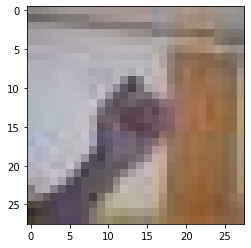

In [65]:
plt.imshow(x_train_norm[100])
print('라벨: ', y_train[100], '[가위 : 0, 바위 : 1, 보 : 2]')

라벨:  1 [가위 : 0, 바위 : 1, 보 : 2]


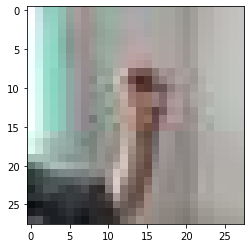

In [66]:
plt.imshow(x_test_norm[100])
print('라벨: ', y_test[100], '[가위 : 0, 바위 : 1, 보 : 2]')

# 2 딥러닝 네트워크 설계 

## 2-1. Sequential API로 모델 설계하기

> ■ 이미지 차원은 (28, 28, 3)<br>
> ■ 1번째 Convolution layer의 feature수는 16, 2번째는 32<br>
> ■ Dense layer의 출력 수는 label수에 같은 3에 고정<br>
> ■ 총 7층의 CNN으로 구성 (전체적으로 숫자인식의 경우와 비슷하게 초기설정함)


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                            
                                                                 
 flatten_30 (Flatten)        (None, 800)               0         
                                                                 
 dense_60 (Dense)            (None, 32)              

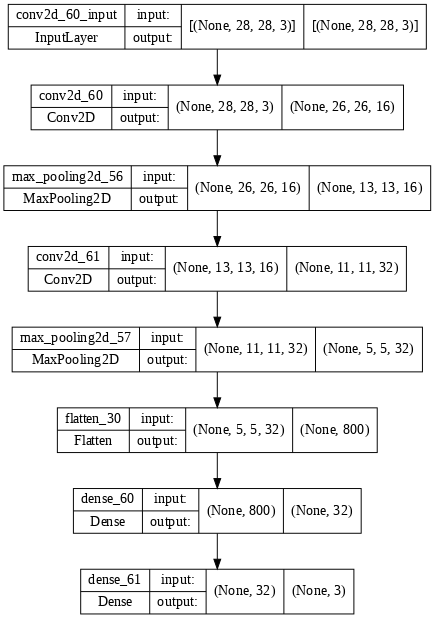

In [81]:
n_channel_1=16
n_channel_2=32
n_dense=32

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

keras.utils.plot_model(model, show_shapes=True, dpi = 70)

# 3 학습

## 3-1. 모델 훈련시키기
> ■ epoch는 추세확인을 위해 50으로 크게 시작했고, 34회에서 accuracy 1.0에 도달함을 확인함.

In [87]:
n_train_epoch=50

model.fit(x_train_norm, y_train, epochs=n_train_epoch)

Epoch 1/50
10/10 [==============================] - 0s 28ms/step - loss: 4.7171e-04 - accuracy: 1.0000
Epoch 2/50
10/10 [==============================] - 0s 30ms/step - loss: 4.7158e-04 - accuracy: 1.0000
Epoch 3/50
10/10 [==============================] - 0s 32ms/step - loss: 4.5867e-04 - accuracy: 1.0000
Epoch 4/50
10/10 [==============================] - 0s 35ms/step - loss: 4.5278e-04 - accuracy: 1.0000
Epoch 5/50
10/10 [==============================] - 0s 32ms/step - loss: 4.8013e-04 - accuracy: 1.0000
Epoch 6/50
10/10 [==============================] - 0s 31ms/step - loss: 4.1054e-04 - accuracy: 1.0000
Epoch 7/50
10/10 [==============================] - 0s 37ms/step - loss: 4.1917e-04 - accuracy: 1.0000
Epoch 8/50
10/10 [==============================] - 0s 46ms/step - loss: 4.2292e-04 - accuracy: 1.0000
Epoch 9/50
10/10 [==============================] - 0s 42ms/step - loss: 3.9017e-04 - accuracy: 1.0000
Epoch 10/50
10/10 [==============================] - 0s 22ms/step - loss:

# 4. 평가

## 4-1. 1차 평가 결과
> ■ accuracy 38%대 로 매우 저조함. <br>
> ■ 적절치 않은 하이퍼파라미터들을 사용했을 것으로 짐작됨.

In [83]:
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 5.0404 - accuracy: 0.3267 - 225ms/epoch - 22ms/step
test_loss: 5.040440082550049 
test_accuracy: 0.3266666531562805


# 5. 개선

## 5-1. 개선점

> ■ 기본적으로 구조변경없이, 다음과 같은 하이퍼파라미터만 변경해서 개선해 보기로 함.<br>
> ■ epoch 수를 8로 조정 (overfitting대응) <br>
> ■ 제3의 convolution layer를 추가함
> ■ 3번째 convolution layer의 n_channel_3=64로 정함
> ■ n_dense=64로 layer수가 증가함에 따라 크게 함              (32 -> 64) 


In [92]:
# 모델 설계
n_channel_1=16
n_channel_2=32
n_channel_3=64
n_dense=64

model22=keras.models.Sequential()
model22.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model22.add(keras.layers.MaxPool2D(2,2))
model22.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model22.add(keras.layers.MaxPooling2D((2,2)))
model22.add(keras.layers.Conv2D(n_channel_3, (3,3), activation='relu'))
model22.add(keras.layers.MaxPooling2D((2,2)))
model22.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model22.add(keras.layers.Dense(n_dense, activation='relu'))
model22.add(keras.layers.Dense(3, activation='softmax'))

model22.summary()

model22.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 학습
n_train_epoch=8
model22.fit(x_train_norm, y_train, epochs=n_train_epoch)

# 평가
test_loss, test_accuracy = model22.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_74 (Conv2D)          (None, 3, 3, 64)          18496     
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 1, 1, 64)       

## 5-2. 개선 결과
<pre>■ 우선, CNN구조를 convolution layer를 추가하는 식으로 변경함에 따라 accuracy 53%대로 향상되었다.
■ convolution layer를 한개 더 추가 하므로, CNN이 보다 더 추상적인 정보 표현을 더 잘 한 거 같고,
   overfitting을 대응하기 위하여, epoch수, Dropout layer추가한 부분이 도움이 되었던 거 같다.
■ 보다 체계적인 하이퍼파라미터 설정을 위하여, validation test를 했어야 했으나,
   시간상, 못 한것이 아쉬웠었다.